# Testing

C:\Users\vinir\AppData\Local\Temp\ipykernel_8852\3511819452.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='vlag')


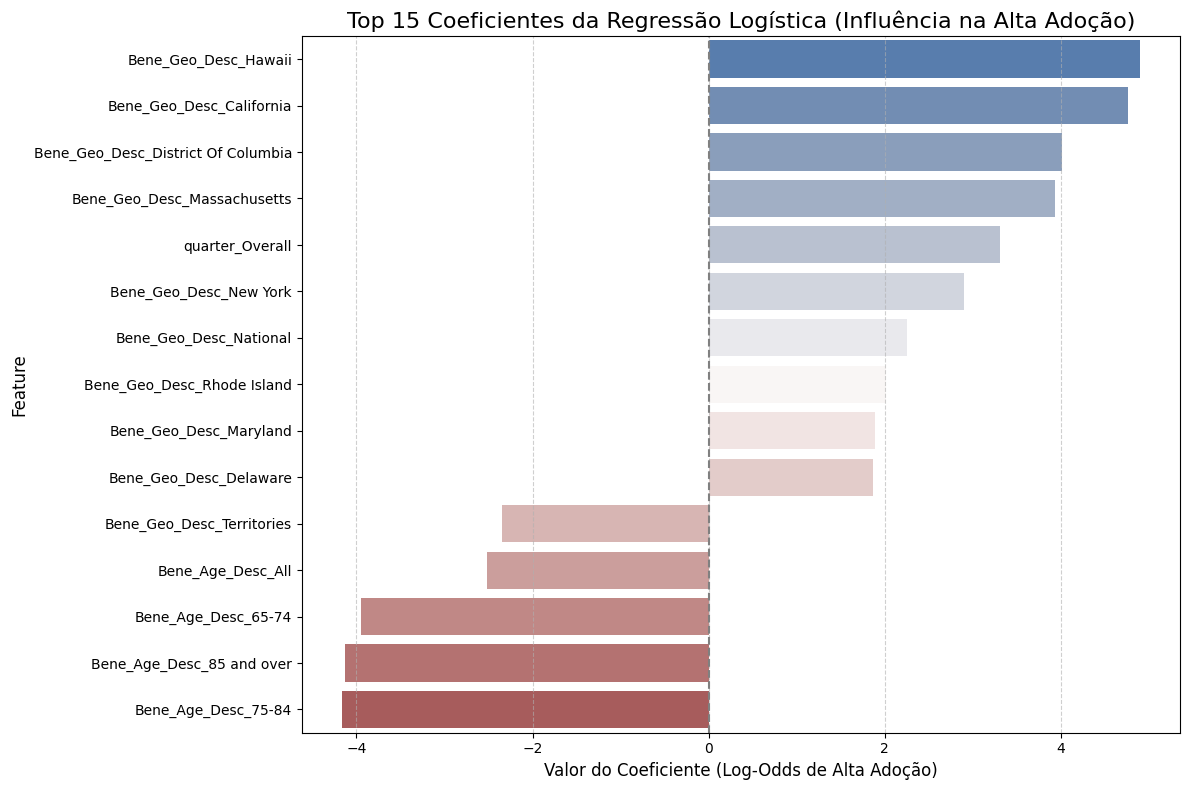

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- PARTE 0: Carregamento e Pré-processamento de Dados ---

# Carregar o dataset
file_name = "TMEDTREND_PUBLIC_250827.csv"
df = pd.read_csv(file_name)

# 1. Limpeza de Dados e Criação da Variável Alvo
df_clean = df.dropna(subset=['Pct_Telehealth']).copy()
median_threshold = df_clean['Pct_Telehealth'].median()
df_clean['High_Telehealth'] = (df_clean['Pct_Telehealth'] > median_threshold).astype(int)

# Definição de Features (X) e Target (y)
features = ['Year', 'quarter', 'Bene_Geo_Desc', 'Bene_Race_Desc', 
            'Bene_Sex_Desc', 'Bene_Age_Desc', 'Bene_RUCA_Desc']
X = df_clean[features]
y = df_clean['High_Telehealth']

# Divisão Treino / Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definição dos transformadores
categorical_cols = ['quarter', 'Bene_Geo_Desc', 'Bene_Race_Desc', 
                    'Bene_Sex_Desc', 'Bene_Age_Desc', 'Bene_RUCA_Desc']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

# 2. Definição e Treinamento do Modelo (Criação do objeto 'model')
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# O objeto 'model' é treinado e agora está definido
model.fit(X_train, y_train)


# --- PARTE 1: Extração de Coeficientes e Nomes das Features (Seu Código) ---

# 1. Acessar o estimador de Regressão Logística treinado dentro do Pipeline
log_reg_estimator = model.named_steps['classifier']
coefficients = log_reg_estimator.coef_[0]

# 2. Acessar o preprocessor treinado
preprocessor = model.named_steps['preprocessor']

# 3. Obter os nomes das features após o One-Hot Encoding e Scaling
feature_names_out = preprocessor.get_feature_names_out()

# 4. Limpar e Renomear as Features para melhor leitura 
clean_feature_names = [name.split('__')[-1] for name in feature_names_out]

# 5. Combinar Coeficientes e Nomes em um DataFrame
coef_df = pd.DataFrame({
    'Feature': clean_feature_names,
    'Coefficient': coefficients
})

# 6. Calcular a Magnitude (Valor Absoluto) para encontrar os mais influentes
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])

# 7. Ordenar pela Magnitude e selecionar o Top 15
top_n = 15
top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(top_n)

# 8. Reordenar para o gráfico (pelo valor do coeficiente, para visualização de impacto)
top_features = top_features.sort_values(by='Coefficient', ascending=False)


# --- PARTE 2: Geração do Gráfico ---

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='vlag')
plt.title(f'Top {top_n} Coeficientes da Regressão Logística (Influência na Alta Adoção)', fontsize=16)
plt.xlabel('Valor do Coeficiente (Log-Odds de Alta Adoção)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='grey', linestyle='--') # Linha de referência no zero
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()